In [4]:
import uproot
import pandas as pd
import sys,os, time, glob, re  
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm       
tqdm.pandas()

# import the custom python module
import muonfixedid, chamberlist_run3   
import splitter_regions_Run2
import mdtCalib_functions
import awkward as ak

# inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0120.ntuple.root'
# inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0051.ntuple.root'  #BMG
# inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0113.ntuple.root'    #BIS7A02
# inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0114.ntuple.root'      #BIS7A04
# inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0115.ntuple.root'     #BIS7A06
# inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0116.ntuple.root'      #BIS7A08
# inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0117.ntuple.root'        #BIS7A10
# inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0118.ntuple.root'      #BIS7A12
# inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0119.ntuple.root'        #OPERATING_CHAMBER

CHAMBER_TO_INPUT_CAL = {
    "BMG": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0051.ntuple.root',
    "BIS7A02": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0113.ntuple.root',
    "BIS7A04": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0114.ntuple.root',
    "BIS7A06": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0115.ntuple.root',
    "BIS7A08": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0116.ntuple.root',
    "BIS7A10": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0117.ntuple.root',
    "BIS7A12": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0118.ntuple.root',
    "BIS7A14": 'data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0119.ntuple.root'
}

OPERATING_CHAMBER = "BIS7A02"
inputCalibNtuple = CHAMBER_TO_INPUT_CAL[OPERATING_CHAMBER]
act_time_window=1.3*(10**(-6))
ADC_CUT_VAL = 50
noise_thresh=20000

#tube_id gives the tube index
def tube_id(row, chamber):
    # Grab the tube name
    x = row.iloc[0]
    # Split into components that were separated by a '-'
    ml_index=int(x.split('-')[1])
    ly_index =int(x.split('-')[2])
    tube_no =int(x.split('-')[3])

    # Calculate unique tube id 
    return (ml_index-1)*chamberlist_run3.MDTnTml(chamber,1) + (ly_index-1)*chamberlist_run3.MDTnTly(chamber,ml_index) + tube_no

#Noise rate
def noise_rate(df_raw_chamber, chamber):
    # Aggregate tube hits with pandas value_counts() method
    tube_hits=df_raw_chamber.rawMdt_tubeInfo.value_counts()

    # Recalculate all noise_rates and construct them into a new Series
    noise_rate=tube_hits/(act_time_window*total_evts)
    
    # Convert to dataframe
    noise_rate_df = noise_rate.reset_index()
    
    # Add column names to two columns
    noise_rate_df.columns = ['Tube_Name', 'Noise_Rate']
    
    # Create new column for tube ids and calculate each id inline in the tube_id() function
    noise_rate_df['Tube_ID'] = noise_rate_df.apply(lambda row: tube_id(row, chamber), axis=1)
    
    return noise_rate_df #returns a dataframe

#Introduce adc_cut
def adc_cut(df_raw_chamber,chamber,cut):  #returns complete dataframe just introducing adc_cut(doesn't give any info on noise_rate etc)
    df_raw_adc=df_raw_chamber[df_raw_chamber['rawMdt_adc']>cut]
    return df_raw_adc

#Extract list of noisy_tubes and dataframe removing noisy_tubes
def noise_tubes(df,chamber,cut,noise_thresh):
    df_raw_adc_cut=adc_cut(df,OPERATING_CHAMBER,cut)  
    df_noise_adc=noise_rate(df_raw_adc_cut,OPERATING_CHAMBER)    #creating a separate dataframe for noise_ate and tube_id from after adc_cut df
    noisy_tubes=df_noise_adc[df_noise_adc['Noise_Rate']>noise_thresh]  #Extract all the rows for noise_rate>20k from the df_noise_rate dataframe
    noisy_list=noisy_tubes['Tube_Name']      #extract names for all the noisy tubes extracted above
    print('List of noisy_tubes for chamber %s'%(chamber),noisy_list)

def df_filtered(df_raw_chamber,chamber,cut,noise_thresh):
    df_raw_adc_cut=adc_cut(df_raw_chamber,OPERATING_CHAMBER,cut)  #Complete dataframe after introducing adc_cut
    df_noise_adc=noise_rate(df_raw_adc_cut,OPERATING_CHAMBER)    #creating a separate dataframe for noise_ate and tube_id from after adc_cut df
    noisy_tubes=df_noise_adc[df_noise_adc['Noise_Rate']>noise_thresh]  
#make a dataframe excluding noisy tubes
    df_raw_chamber_noisy_filtered=df_raw_adc_cut[~df_raw_adc_cut['rawMdt_tubeInfo'].isin(noisy_tubes['Tube_Name'])]
    return df_raw_chamber_noisy_filtered

#Noise_Rate v/s Tube_Id Plot
def plot_for_noise_rate(df_raw_chamber, chamber, cut,noise_thresh):
    run='456729'
    fig,axes = plt.subplots(figsize=(28, 32), nrows = 3, ncols = 1)  
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)
    alpha_value = 1  #Transparency
    
    df_noise_rate=noise_rate(df_raw_chamber,OPERATING_CHAMBER)
    df_noise_rate_sorted=df_noise_rate.sort_values(by='Tube_ID', ascending=True)
    
    axes[0].bar(df_noise_rate_sorted['Tube_ID'].astype(str), df_noise_rate_sorted['Noise_Rate'], color='skyblue')
    axes[0].set_title('Noise Rate without adc cut')
    axes[0].set_xlabel('Tube ID')
    axes[0].set_ylabel('Noise Rate')
    axes[0].set_xticks(np.arange(0, len(df_noise_rate_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut
    df_raw_chamber_with_adc_cut=adc_cut(df_raw_chamber,chamber,cut)
    df_noise_rate_with_adc_cut = noise_rate(df_raw_chamber_with_adc_cut,OPERATING_CHAMBER)
    df_noise_rate_with_adc_cut_sorted = df_noise_rate_with_adc_cut.sort_values(by='Tube_ID', ascending=True) 


    axes[1].bar(df_noise_rate_with_adc_cut_sorted['Tube_ID'].astype(str), df_noise_rate_with_adc_cut_sorted['Noise_Rate'], color='skyblue')
    axes[1].set_title('Noise Rate with adc cut before removing noisy tubes')
    axes[1].set_xlabel('Tube ID')
    axes[1].set_ylabel('Noise Rate')
    axes[1].set_xticks(np.arange(0, len(df_noise_rate_with_adc_cut_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut and noisy tubes removed
    df_raw_filtered=df_filtered(df_raw_chamber,chamber,cut,noise_thresh)
    df_noise_rate_removed=noise_rate(df_raw_filtered,chamber)
    df_noise_rate_removed_sorted=df_noise_rate_removed.sort_values(by='Tube_ID', ascending=True) 
    
    axes[2].bar(df_noise_rate_removed_sorted['Tube_ID'].astype(str), df_noise_rate_removed_sorted['Noise_Rate'], color='skyblue')
    axes[2].set_title('Noise Rate with adc cut after removing noisy tubes')
    axes[2].set_xlabel('Tube ID')
    axes[2].set_ylabel('Noise Rate')
    axes[2].set_xticks(np.arange(0, len(df_noise_rate_removed_sorted['Tube_ID'])+1, 50))
    # fig.savefig('Noise_rate for %s'%(chamber))
    plt.show()

# plotting function for chamber hitMap and noise_hits  
def plotHitMap(df,chamber,plot_title):
    chamberinfo = list(df.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    ax.set_title(plot_title)
    
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()
    fig.savefig('Hitmap for %s'%(chamber))

# raw ADC and TDC hits plot with ADC cut at 50
def RawMdtplots(df,chamber,title):

    fig,axes = plt.subplots(figsize=(8, 3), nrows = 1, ncols = 2)
    # fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.4, hspace = 0.4)
    # fig.set_title(title, fontsize=20)
       
    # ADC count without cut
    mdt_adc = df.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    
    xadc, xbins, patch = axes[0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0].set_xlim(min_adc,max_adc)
    axes[0].set_xlabel('adcCount',fontsize=15)
    axes[0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0].grid()
    axes[0].set_title(f'{chamber,title}_rawADC')
    
    
    # # raw TDC spectrum
    mdt_tdc = df.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[1].set_xlim(min_tdc,max_tdc)
    axes[1].set_xlabel('tdcCount',fontsize=15)
    axes[1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1].grid()
    axes[1].set_title(f'{chamber,title}_rawTDC')
    
    fig.patch.set_facecolor('white')
    fig.savefig('Adc_Tdc for %s'%(chamber))
    plt.show()

def findAdcAfterFirstSpike():
    # Function that will show us where spikes at the start of adc counts end
    adc_cut_counts_sorted = df_raw_chamber_filtered['rawMdt_adc'].value_counts().sort_index()
    
    found_peak = False
    prev_count = None
    prev_adc = None
    found_increase = False
    for adc_cut, count in adc_cut_counts_sorted.items():
        print("Current adc_cut: " + str(adc_cut) + ", current count: " + str(count))
        if prev_count != None:
            if found_peak == False:
                # check for the peak
                if count < prev_count:
                    found_peak = True
            else:
                if count > prev_count and found_increase == False:
                    print("Found when count began increasing. Adc: " + str(prev_adc) + ", count: " + str(prev_count))
                    found_increase = True
        if adc_cut >= 100:
            break
        prev_count = count
        prev_adc = adc_cut

f=uproot.open(inputCalibNtuple)  

tree=f['Segments']                                     
run = inputCalibNtuple.split('0',1)[1][:6]        
region = int(inputCalibNtuple.split("-", 1)[1][:4])
lb = inputCalibNtuple.split("-", 1)[0][-9:]          
branchList=tree.keys()                                  
branchPrefix=['trk', 'trkHit', 'event', 'rawMdt']       
branchMapping={key : [] for key in branchPrefix}          # branchMapping is a dictionary

for branch in branchList:
    branchName, variableName= branch.split('_', 1)
    if branchName in branchPrefix:
        branchMapping[branchName].append(branch)
        
# convert mdtCalname to mdtHardname by chamberlist.py
chamberInRegion = [chamberlist_run3.MDThardname(chamberlist_run3.MDTindex(x)) for x in splitter_regions_Run2.regionlist[region]]
print('process run %s lumiblock %s region %s, chamberList %s' % (run, lb, region, chamberInRegion))

process run 045672 lumiblock 0000_0004 region 113, chamberList ['IsWRONG', 'BIS7A02', 'EES1A02', 'EES2A02', 'EMS4A02', 'EMS5A02']


In [2]:
df_raw=ak.to_dataframe(tree.arrays(branchMapping['rawMdt']))  #converted awkward array to dataframe df_raw

# expand all raw and trk hits with correct chamberName and tubeInfo
df_raw['rawMdt_tubeInfo'] = df_raw['rawMdt_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
df_raw['rawMdt_station'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:7])
df_raw['rawMdt_type'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:3])

# Creates new dataframe that only contains data for current chamber
DF_OPERATING_CHAMBER = df_raw[df_raw['rawMdt_station']==OPERATING_CHAMBER]

print(df_raw.head(5))

df_all = tree.arrays() #gives total numner of events and not hits
total_evts=len(df_all)

print(f'Total Event in this file is {total_evts}')

                rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                 37   4299.335449   1780.843018   6481.250000   
      1                 37   4299.335449   1780.843018   6345.350098   
      2                 34   4299.335449   1780.843018   6330.250000   
      3                 36   4299.335449   1780.843018   6315.149902   
      4                 34   4299.335449   1780.843018   6300.049805   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0          24649649           118         197  BIS7A02-2-4-50   
      1          24649640           118         197  BIS7A02-2-4-41   
      2          24649639           118         185  BIS7A02-2-4-40   
      3          24649638           118          78  BIS7A02-2-4-39   
      4          24649637           118          71  BIS7A02-2-4-38  

# Tube_index and noise_rate dataframe

In [5]:
# Returns dataframe with tube id, tube name, and noise rate
df_noise_rate=noise_rate(df_raw,OPERATING_CHAMBER)
df_noise_rate

,Tube_Name,Noise_Rate,Tube_ID
0,EMS3A02-1-3-59,611203.937809,215
1,BIS7A02-2-4-18,417812.838203,654
2,BIS7A02-2-4-30,401891.965173,666
3,BIS7A02-2-1-67,319437.138043,379
4,BIS7A02-2-4-39,316563.501572,675
...,...,...,...
15093,BIS5A02-2-1-14,23.174488,326
15094,BOS5A02-1-2-45,23.174488,123
15095,BOS5A02-2-2-7,23.174488,427
15096,BOS5A02-2-1-5,23.174488,317


In [6]:
# Prints list of noisy tubes
noise_tubes(DF_OPERATING_CHAMBER,OPERATING_CHAMBER,ADC_CUT_VAL,noise_thresh)

List of noisy_tubes for chamber BIS7A02 0     BIS7A02-2-1-67
1     BIS7A02-2-3-67
2     BIS7A02-2-4-66
3     BIS7A02-2-4-67
4     BIS7A02-2-4-65
5     BIS7A02-2-4-30
6     BIS7A02-2-4-60
7     BIS7A02-2-4-39
8     BIS7A02-2-4-18
9     BIS7A02-2-2-67
10    BIS7A02-2-1-68
11    BIS7A02-2-4-64
12    BIS7A02-2-4-56
13    BIS7A02-2-3-97
14    BIS7A02-1-4-78
15    BIS7A02-2-4-59
16    BIS7A02-2-1-97
17    BIS7A02-1-1-70
18    BIS7A02-2-4-68
19    BIS7A02-2-1-96
20    BIS7A02-2-2-68
21    BIS7A02-2-4-38
22    BIS7A02-2-4-37
23    BIS7A02-2-4-19
24    BIS7A02-2-3-66
25    BIS7A02-2-4-54
26    BIS7A02-2-1-69
27    BIS7A02-2-3-68
28    BIS7A02-2-4-97
29    BIS7A02-2-4-40
30    BIS7A02-2-4-17
Name: Tube_Name, dtype: object


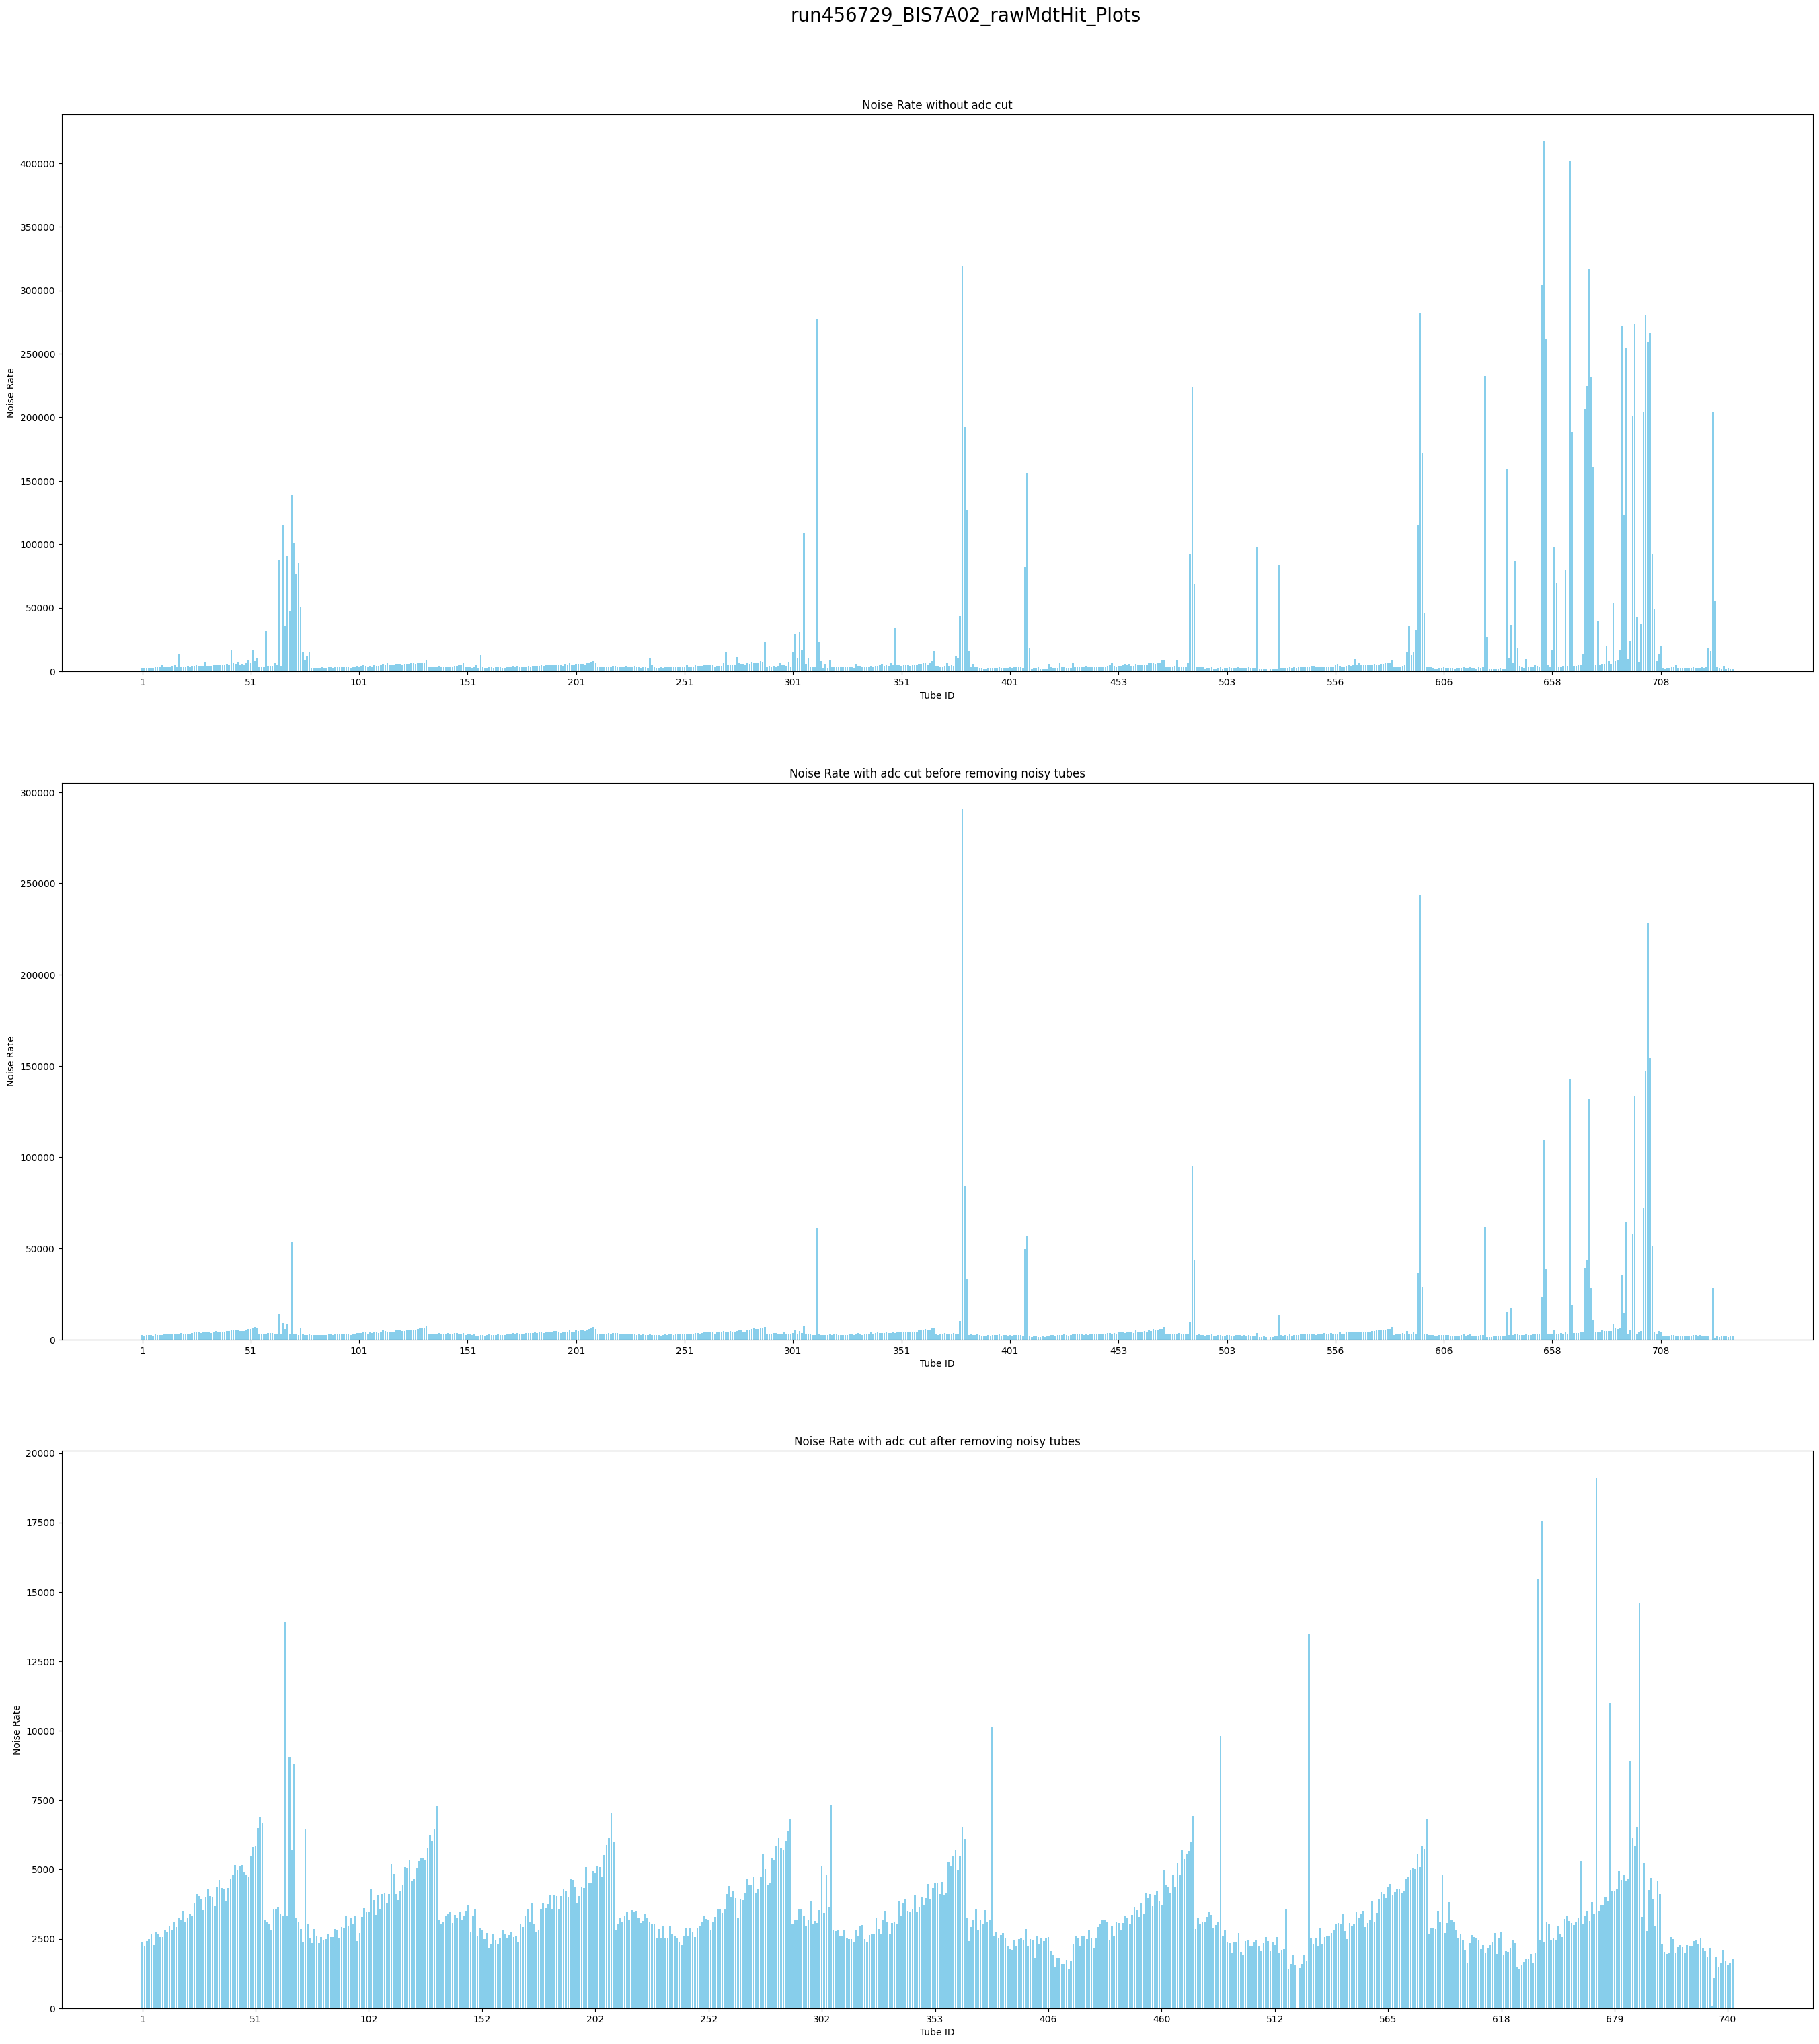

In [7]:
# Plots noise rate of each tube ID
plot_for_noise_rate(DF_OPERATING_CHAMBER,OPERATING_CHAMBER,ADC_CUT_VAL,noise_thresh)

# Trials

# Hitmap plots

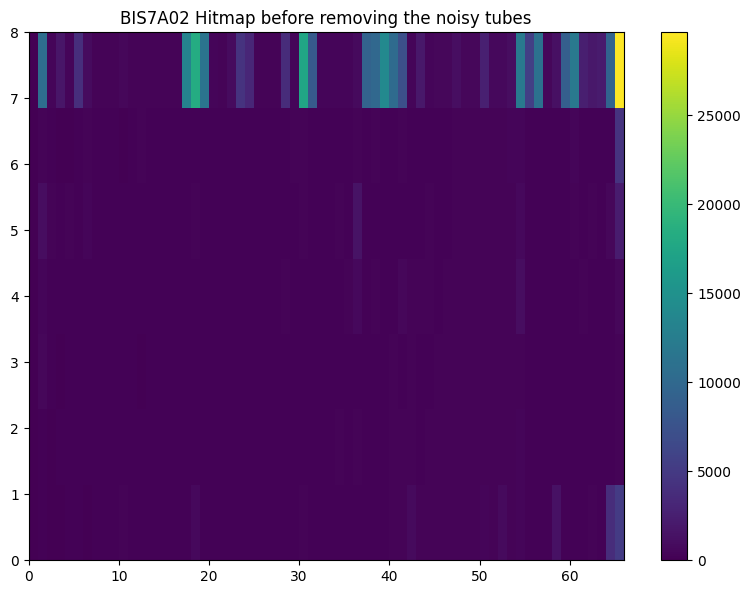

In [8]:
#HitMap Plots for both filtered and non-filtered
plotHitMap(DF_OPERATING_CHAMBER,OPERATING_CHAMBER,f"{OPERATING_CHAMBER} Hitmap before removing the noisy tubes")

#Extracts filtered dataset for assigned chamber
df_raw_chamber_filtered = df_filtered(DF_OPERATING_CHAMBER,OPERATING_CHAMBER,ADC_CUT_VAL,noise_thresh)

plotHitMap(df_raw_chamber_filtered,OPERATING_CHAMBER,f"{OPERATING_CHAMBER} Hitmap after removing the noisy tubes") #filtered

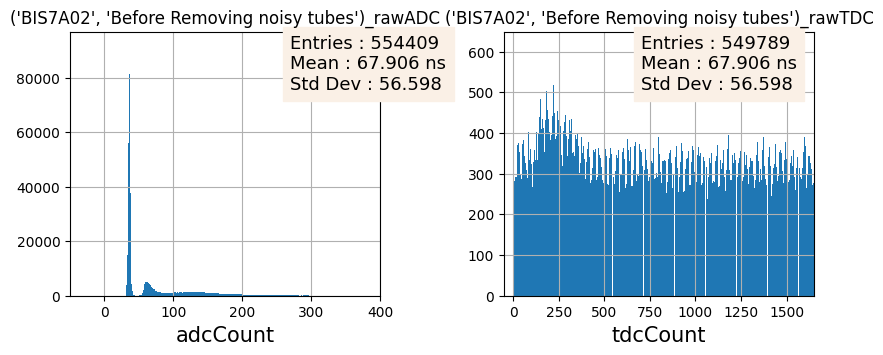

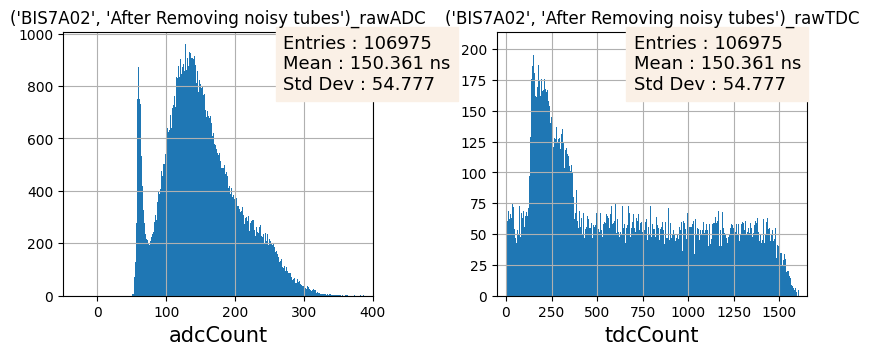

In [11]:
# plotRawMdtHits(df_raw,OPERATING_CHAMBER)
RawMdtplots(DF_OPERATING_CHAMBER,OPERATING_CHAMBER,'Before Removing noisy tubes')  #crude plot
RawMdtplots(df_raw_chamber_filtered,OPERATING_CHAMBER,'After Removing noisy tubes') #filtered plot

In [120]:
d=df_raw[df_raw['rawMdt_tubeInfo']=='BIS7A02-2-4-40']
d['rawMdt_adc'].unique()

array([ 34,  59,  35, 132,  64,  61,   0,  63,  60,  58,  33, 177, 201,
        66,  65, 170,  62, 115,  36,  32, 239,  86,  68,  92,  57,  42,
        96,  44,  38,  56,  71, 116, 141,  47,  67, 146, 117,  37, 140,
       237,  70, 125,  69, 190, 113, 138, 102, 167,  46, 144, 163, 139,
       171, 135, 121, 165, 234,  39, 109, 118, 161, 173, 149, 145, 253,
       162, 159,  83, 120, 168, 148,  99,  97, 220, 187, 142, 151, 154,
       136, 199,  85, 247,  74,  50, 216, 206, 203,  45, 189, 133, 110,
       184, 225, 207, 156, 192, 103,  31,  94, 176, 100, 197, 128, 181,
       245, 155, 175, 264, 129, 131, 233,  54,  87, 164, 137,  72, 258],
      dtype=int32)

/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_16529/2432208190.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]


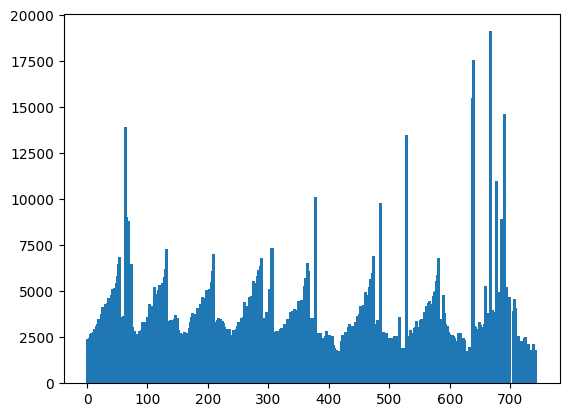

,Tube_Name,Noise_Rate,Tube_ID
0,BIS7A02-2-4-31,19118.952328,667
1,BIS7A02-2-4-3,17543.087166,639
2,BIS7A02-2-4-1,15480.557764,637
3,BIS7A02-2-4-55,14599.927232,691
4,BIS7A02-1-1-64,13927.867090,64
...,...,...,...
698,BIS7A02-2-2-98,1390.469260,518
699,BIS7A02-2-1-105,1390.469260,417
700,BIS7A02-2-4-98,1089.200920,734
701,BIS7A02-2-4-96,69.523463,732


In [78]:
df_11=df_raw_chamber_filtered[(df_raw_chamber_filtered['rawMdt_adc']>50) & (df_raw_chamber_filtered['rawMdt_adc']<90)]  #Extract all the rows for noise_rate>20k from the df_noise_rate dataframe

# df_11
noise_rate_for_75_adc=noise_rate(df_raw_chamber_filtered,OPERATING_CHAMBER)

plt.bar(noise_rate_for_75_adc['Tube_ID'],noise_rate_for_75_adc['Noise_Rate'],width=5)
plt.show()
noise_rate_for_75_adc

4162.639055538161
           Tube_Name    Noise_Rate  Tube_ID
0     BIS7A02-2-4-31  19118.952328      667
1      BIS7A02-2-4-3  17543.087166      639
2      BIS7A02-2-4-1  15480.557764      637
3     BIS7A02-2-4-55  14599.927232      691
6     BIS7A02-2-4-41  11007.881643      677
..               ...           ...      ...
681  BIS7A02-2-3-101   1668.563112      629
684  BIS7A02-2-3-105   1622.214137      633
692  BIS7A02-2-3-100   1552.690674      628
693   BIS7A02-2-3-98   1506.341699      626
697   BIS7A02-2-3-99   1413.643748      627

[74 rows x 3 columns]


/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_16529/2432208190.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]


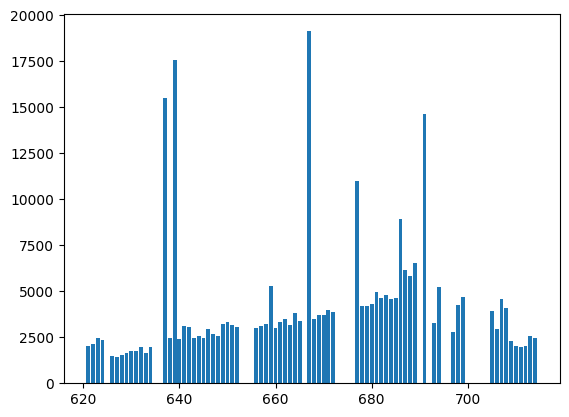

In [89]:
#620-715
df_12=noise_rate(df_raw_chamber_filtered,OPERATING_CHAMBER)
df_13=df_12[(df_12['Tube_ID']>620) & (df_12['Tube_ID']<715)]



plt.bar(df_13['Tube_ID'],df_13['Noise_Rate'])
print(df_13['Noise_Rate'].mean())
print(df_13)